In [1]:
import pandas as pd
import acbm
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from typing import Optional, Tuple


# Read in the data 

In [2]:
# NTS data 
legs_nts = pd.read_parquet(
    acbm.root_path / "data/external/nts/filtered/nts_trips.parquet"
)

legs_nts = legs_nts[legs_nts["TravDay"] == 3]

# Model outputs 
legs_acbm = pd.read_csv(
    acbm.root_path / "data/processed/activities_pam/legs.csv"
)
legs_acbm_geo = pd.read_parquet(
    acbm.root_path / "data/processed/activities_pam/legs_with_locations.parquet"
)



In [3]:
legs_acbm


,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,origin activity,destination activity,mode,seq,tst,tet,duration
0,0,199,89,NaN,E00059031,E00058720,other,home,other,walk,1.0,1900-01-01 10:00:00,1900-01-01 10:45:00,0:45:00
1,1,199,89,NaN,E00058720,E00059031,home,other,home,walk,2.0,1900-01-01 10:45:00,1900-01-01 11:30:00,0:45:00
2,2,199,89,NaN,E00059031,E00057312,shop,home,shop,car,3.0,1900-01-01 12:00:00,1900-01-01 12:10:00,0:10:00
3,3,199,89,NaN,E00057312,E00059031,home,shop,home,car,4.0,1900-01-01 12:45:00,1900-01-01 12:55:00,0:10:00
4,4,199,89,NaN,E00059031,E00058564,work,home,work,car,5.0,1900-01-01 13:30:00,1900-01-01 13:50:00,0:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970,14970,794026,334502,NaN,E00056891,E00057826,home,escort,home,car,4.0,1900-01-01 20:45:00,1900-01-01 21:05:00,0:20:00
14971,14971,794027,334502,NaN,E00057826,E00057536,escort,home,escort,car,1.0,1900-01-01 07:40:00,1900-01-01 07:55:00,0:15:00
14972,14972,794027,334502,NaN,E00057536,E00057826,home,escort,home,pt,2.0,1900-01-01 15:00:00,1900-01-01 15:55:00,0:55:00
14973,14973,794027,334502,NaN,E00057826,E00056882,other,home,other,pt,3.0,1900-01-01 18:35:00,1900-01-01 19:35:00,1:00:00


### Preprocess: Rename columns

In [4]:
# rename origin activity and destination activity columns

legs_acbm = legs_acbm.rename(columns={"origin activity": "oact", "destination activity": "dact"})
legs_acbm_geo = legs_acbm_geo.rename(columns={"origin activity": "oact", "destination activity": "dact"})


# rename distance column in NTS
legs_nts = legs_nts.rename(columns={"TripDisIncSW": "distance"})

### Preprocess: Edit distance column

The NTS distance is in miles, but the distance we are using for acbm is kms. Convert the NTS distance to kms.

In [5]:
# convert legs_nts["distance"] from miles to km

legs_nts["distance"] = legs_nts["distance"] * 1.60934

### Preprocess: Add columns

In [6]:
# Create hour column 

# acbm - tst is in datetime format
# Convert tst to datetime format and extract the hour component in one step
legs_acbm['tst_hour'] = legs_acbm['tst'].apply(lambda x: pd.to_datetime(x).hour)
legs_acbm['tet_hour'] = legs_acbm['tet'].apply(lambda x: pd.to_datetime(x).hour)

# nts - tst is in minutes
# Convert legs_nts["tst"] from minutes to hours
legs_nts['tst_hour'] = legs_nts['tst'] // 60
legs_nts['tet_hour'] = legs_nts['tet'] // 60

In [7]:

legs_nts[
    [
        "seq",
        "ozone",
        "dzone",
        "oact",
        "dact",
        "mode",
        "tst",
        "tet",
        "tst_hour",
        "tet_hour",
    ]
]

,seq,ozone,dzone,oact,dact,mode,tst,tet,tst_hour,tet_hour
4659590,3,8,8.0,shop,home,car,795.0,810.0,13.0,13.0
4659597,1,2,2.0,home,medical,car,505.0,525.0,8.0,8.0
4659609,1,8,7.0,home,work,pt,445.0,556.0,7.0,9.0
4659616,1,8,8.0,home,other,car,720.0,750.0,12.0,12.0
4659617,3,8,8.0,visit,home,car,985.0,1041.0,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...
5150053,6,9,9.0,escort,home,car,1020.0,1035.0,17.0,17.0
5150079,1,9,8.0,home,education,car,480.0,525.0,8.0,8.0
5150080,2,8,9.0,education,home,car,965.0,1035.0,16.0,17.0
5150098,1,9,9.0,home,shop,car,645.0,660.0,10.0,11.0


# Compare distributions between NTS and output

# Matching 

## Matching: Trip Purpose 

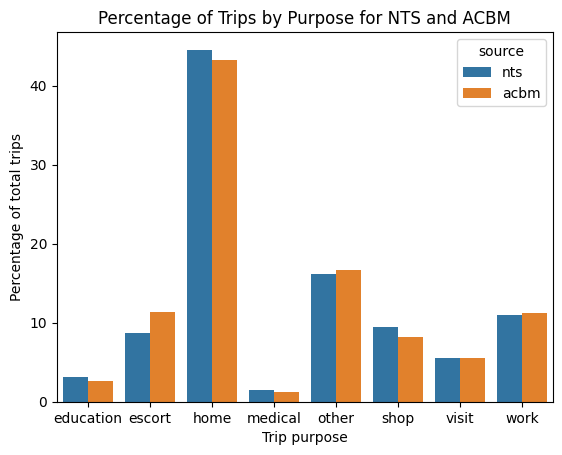

In [8]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
purpose_nts = legs_nts.groupby("dact").size().reset_index(name="count")
purpose_nts["source"] = "nts"

# ACBM
purpose_acbm = legs_acbm.groupby("dact").size().reset_index(name="count")
purpose_acbm["source"] = "acbm"

# Combine the data
purpose_compare = pd.concat([purpose_nts, purpose_acbm])

# Calculate the percentage of trips for each mode within each source
purpose_compare["percentage"] = purpose_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=purpose_compare, x="dact", y="percentage", hue="source")
plt.xlabel('Trip purpose')
plt.ylabel('Percentage of total trips')
plt.title('Percentage of Trips by Purpose for NTS and ACBM')
plt.show()

In [9]:
purpose_compare

,dact,count,source,percentage
0,education,1823,nts,3.071143
1,escort,5180,nts,8.726562
2,home,26434,nts,44.532421
3,medical,859,nts,1.447127
4,other,9628,nts,16.219950
5,shop,5621,nts,9.469499
6,visit,3313,nts,5.581293
7,work,6501,nts,10.952004
0,education,389,acbm,2.597663
1,escort,1708,acbm,11.405676


## Matching: Trip Mode 



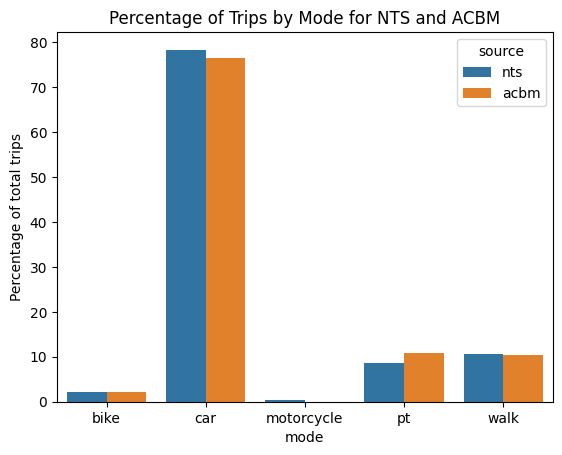

In [10]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
modeshare_nts = legs_nts.groupby("mode").size().reset_index(name="count")
modeshare_nts["source"] = "nts"

# ACBM
modeshare_acbm = legs_acbm.groupby("mode").size().reset_index(name="count")
modeshare_acbm["source"] = "acbm"

# Combine the data
modeshare_compare = pd.concat([modeshare_nts, modeshare_acbm])

# Calculate the percentage of trips for each mode within each source
modeshare_compare["percentage"] = modeshare_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=modeshare_compare, x="mode", y="percentage", hue="source")
plt.ylabel('Percentage of total trips')
plt.title('Percentage of Trips by Mode for NTS and ACBM')
plt.show()

## Matching: Time of Day 

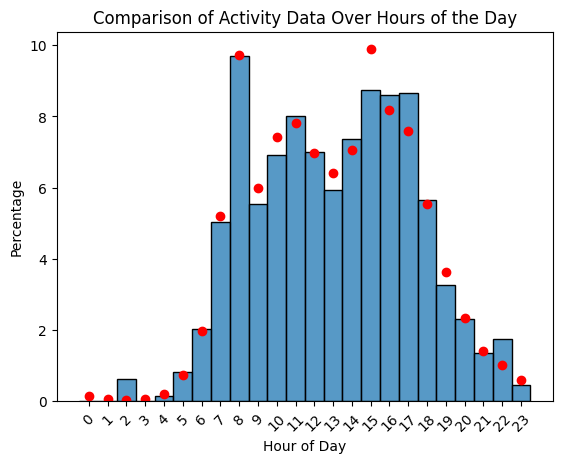

In [11]:
# Calculate the percentage of each hour in legs_acbm_clean['hour']
acbm_hour_counts = legs_acbm['tst_hour'].value_counts(normalize=True).sort_index() * 100

# Convert legs_nts["tst"] from minutes to hours
legs_nts['tst_hour'] = legs_nts['tst'] // 60

# Calculate the percentage of each hour in legs_nts['hour']
nts_hour_counts = legs_nts['tst_hour'].value_counts(normalize=True).sort_index() * 100

# Plot the histogram using seaborn
sns.histplot(legs_acbm['tst_hour'], bins=24, kde=False, discrete=True, stat='percent')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage')
plt.title('Comparison of Activity Data Over Hours of the Day')
plt.xticks(range(0, 24), rotation=45)  # Set x-ticks to represent each hour of the day

# Add dots to represent the percentage values of legs_nts["tst"]
for hour, percent in nts_hour_counts.items():
    plt.plot(hour, percent, 'ro')  # 'ro' means red dot

plt.show()

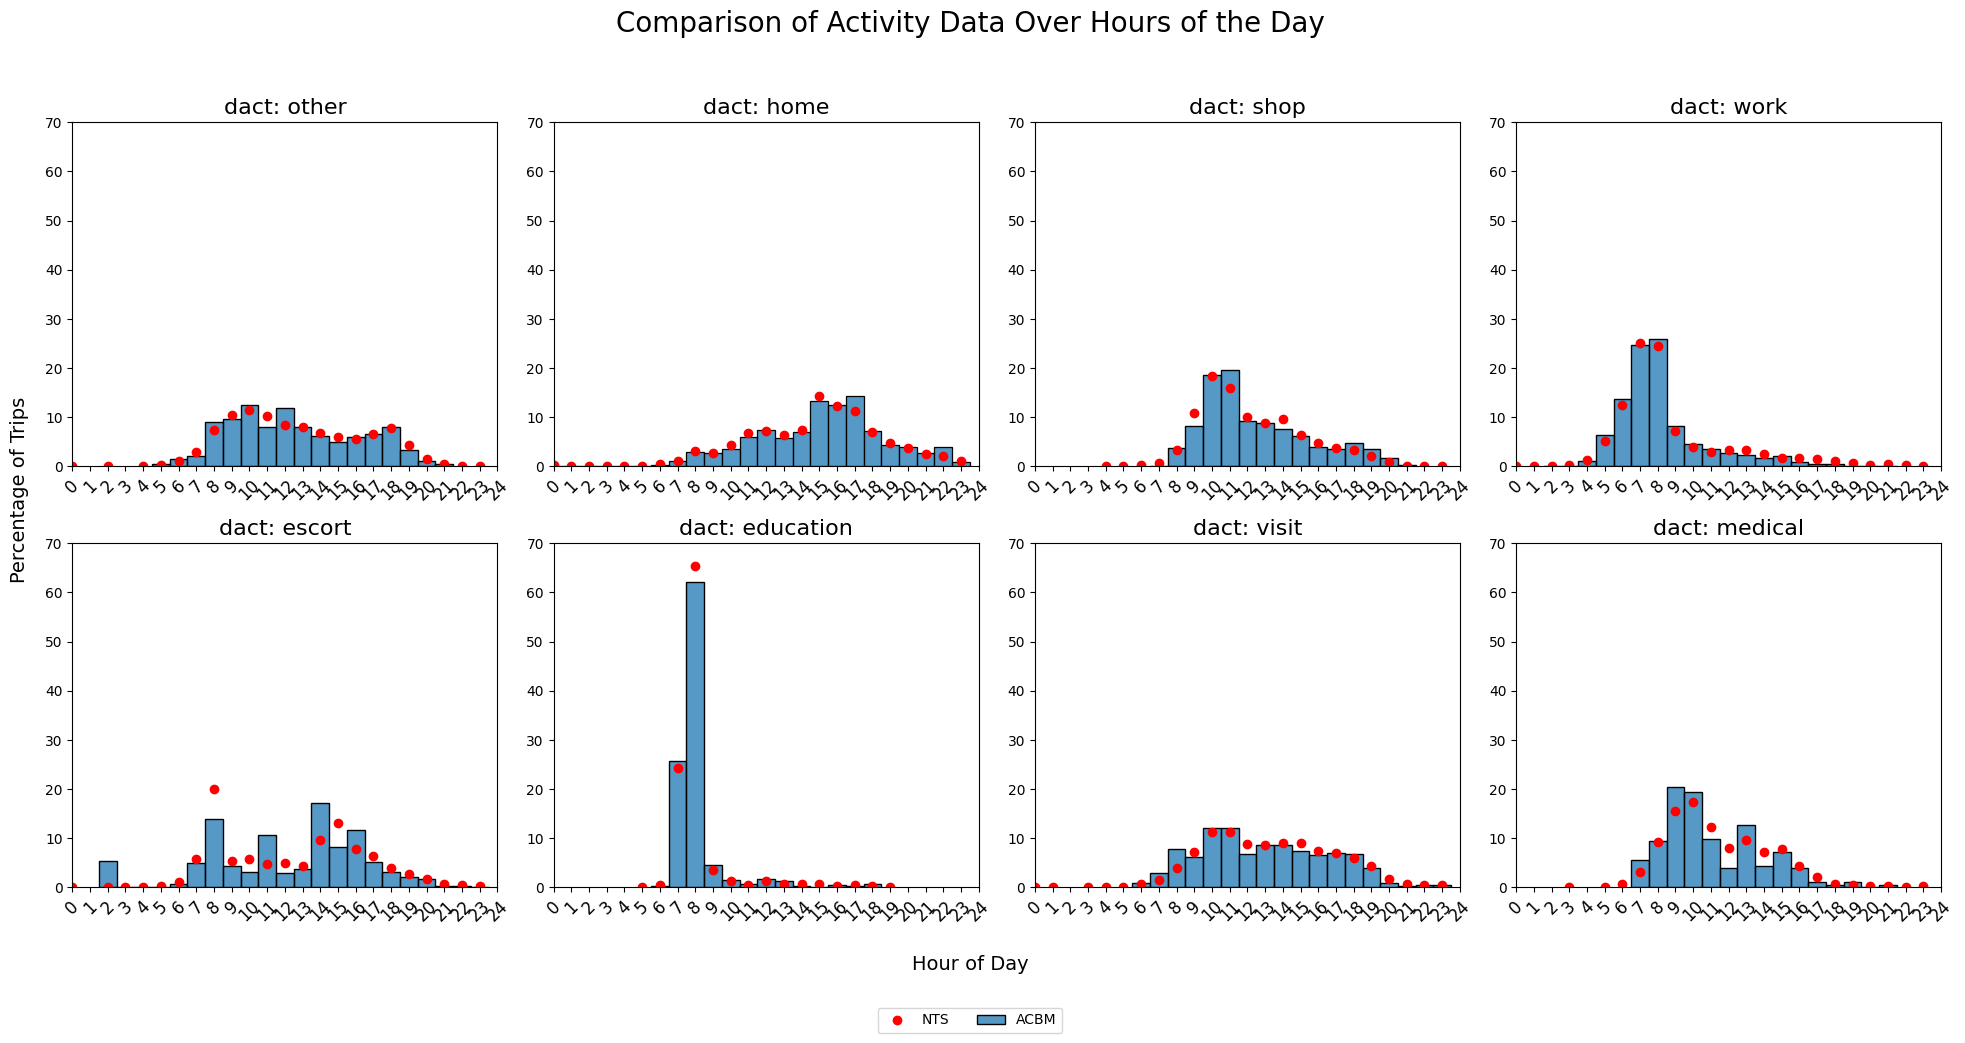

In [36]:
def plot_time_of_day_comparison(legs_acbm: pd.DataFrame, 
                                legs_nts: pd.DataFrame, 
                                activity_column: str = 'dact', 
                                hour_column: str = 'tst_hour', 
                                num_cols: int = 4, 
                                max_y_value: Optional[int] = None,
                                figsize: Optional[Tuple[int, int]] = (20, 5)) -> None:
    """
    Plots a comparison of activity data over the hours of the day for different activity types.

    Parameters
    ----------
    legs_acbm : pd.DataFrame
        DataFrame containing the ACBM data.
    legs_nts : pd.DataFrame
        DataFrame containing the NTS data.
    activity_column : str, optional
        The column name for the activity types. Default is 'dact'.
    hour_column : str, optional
        The column name for the hour values. Default is 'tst_hour'.
    num_cols : int, optional
        The number of columns for the subplots. Default is 4.
    max_y_value : int, optional
        The maximum value for the y-axis. Default is 100.
    figsize : tuple of int, optional
        The size of the figure. Default is (20, 5).

    Returns
    -------
    None
        This function generates and displays a plot but does not return any value.
    """
    # Get unique dact values
    unique_dact_values = legs_acbm[activity_column].unique()

    # Create a figure with subplots
    num_plots = len(unique_dact_values)
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], num_rows * figsize[1]), sharey=False)
    axes = axes.flatten()

    # Iterate over unique dact values and create plots
    for i, dact_value in enumerate(unique_dact_values):
        ax = axes[i]
        acbm_data = legs_acbm[legs_acbm[activity_column] == dact_value]
        nts_data = legs_nts[legs_nts[activity_column] == dact_value]

        # Plot histogram for acbm_data
        hist = sns.histplot(acbm_data[hour_column], bins=24, kde=False, discrete=True, stat='percent', ax=ax, label='ACBM')
        ax.set_xticks(range(0, 25))  # Set x-ticks to represent each hour of the day, including 24
        ax.set_xlim(0, 24)  # Ensure the x-axis covers the full range from 0 to 24
        if max_y_value:
            ax.set_ylim(0, max_y_value) # So that all the plots have the same y axis
        ax.set_title(f'dact: {dact_value}', fontsize=16)
        ax.tick_params(axis='x', rotation=45, labelsize=12)  # Rotate x-axis labels by 45 degrees

        # Remove individual subplot labels
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Add dots to represent the percentage values of legs_nts["hour"]
        nts_hour_counts = nts_data[hour_column].value_counts(normalize=True).sort_index() * 100
        line, = ax.plot(nts_hour_counts.index, nts_hour_counts.values, 'ro', label='NTS')  # 'ro' means red dot

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a main legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    # Add a main title to the figure
    fig.suptitle('Comparison of Activity Data Over Hours of the Day', fontsize=20)

    # Add a single centered x-label and y-label
    fig.text(0.5, 0.02, 'Hour of Day', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Percentage of Trips', va='center', rotation='vertical', fontsize=14)

    # Adjust layout to make room for the main title and labels
    plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
    plt.show()

# Example usage
plot_time_of_day_comparison(legs_acbm, legs_nts, max_y_value=70)

## Matching: Activity Sequences

Abbreviate values

In [13]:
# Abbreviate the column values 

# Mapping dictionary
activity_mapping = {
    'home': 'h',
    'other': 'o',
    'escort': 'e',
    'work': 'w',
    'shop': 'sh',
    'visit': 'v',
    'education': 'edu',
    'medical': 'm'
}

# Replace values in 'origin activity' and 'destination activity' columns
legs_acbm['oact_abr'] = legs_acbm['oact'].replace(activity_mapping)
legs_acbm['dact_abr'] = legs_acbm['dact'].replace(activity_mapping)

# Replace values in 'oact' and 'dact' columns

legs_nts['oact_abr'] = legs_nts['oact'].replace(activity_mapping)
legs_nts['dact_abr'] = legs_nts['dact'].replace(activity_mapping)


Create chains from data and count number of observations of each chain

In [14]:
import pandas as pd
from pandas import DataFrame

def process_sequences(df: DataFrame, 
                      pid_col: str, 
                      seq_col: str, 
                      origin_activity_col: str, 
                      destination_activity_col: str,
                      suffix: str) -> DataFrame:
    """
    Processes a DataFrame to generate activity sequences and counts the number of occurrences of each sequence.


    Parameters
    ----------
    df: pd.DataFrame
        The input DataFrame containing the data.
    pid_col: str
        The name of the column representing the unique identifier for each group.
    seq_col: str
        The name of the column representing the sequence order within each group.
    origin_activity_col: str
        The name of the column representing the origin activity.
    destination_activity_col: str
        The name of the column representing the destination activity.
    suffix: str
        The suffix to be added to the count column name.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the activity sequences and their counts.
        
        activity_sequence           count_{suffix}
        ----------------------      --------------
        home - work - visit - home              5
        home - school - home                    3
        home - work - home                     20
    """
    # Step 1: Sort the DataFrame by 'pid' and 'seq'
    sorted_df = df.sort_values(by=[pid_col, seq_col])
    
    # Step 2: Group by 'pid' and concatenate 'origin activity' values followed by the last 'destination activity' value
    activity_sequence_df = sorted_df.groupby(pid_col).apply(
        lambda x: ' - '.join(x[origin_activity_col].tolist() + [x[destination_activity_col].iloc[-1]])
    ).reset_index()
    
    # Rename the columns for clarity
    activity_sequence_df.columns = [pid_col, 'activity_sequence']
    
    # Step 3: Group by the resulting 'activity_sequence' column and count the number of values in each group
    result = activity_sequence_df.groupby('activity_sequence').size().reset_index(name=f'count_{suffix}')    
    return result

In [15]:
sequence_nts = process_sequences(df = legs_nts, 
                                 pid_col = 'IndividualID', 
                                 seq_col = 'seq', 
                                 origin_activity_col = 'oact', 
                                 destination_activity_col = 'dact',
                                 suffix = 'nts')

sequence_nts

/tmp/ipykernel_540731/491085427.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  activity_sequence_df = sorted_df.groupby(pid_col).apply(


,activity_sequence,count_nts
0,education - education - education,4
1,education - education - education - home,1
2,education - education - education - home - oth...,1
3,education - escort,1
4,education - escort - home,2
...,...,...
1818,work - work - work - home - other - home - oth...,1
1819,work - work - work - home - work - work - home...,1
1820,work - work - work - shop - work,1
1821,work - work - work - work - home - home - home...,1


In [16]:
sequence_acbm = process_sequences(df = legs_acbm,
                                  pid_col = 'pid', 
                                  seq_col = 'seq', 
                                  origin_activity_col = 'oact', 
                                  destination_activity_col = 'dact', 
                                  suffix = 'acbm')

sequence_acbm
                                  

/tmp/ipykernel_540731/491085427.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  activity_sequence_df = sorted_df.groupby(pid_col).apply(


,activity_sequence,count_acbm
0,home - education,10
1,home - education - escort - home,9
2,home - education - escort - shop - home,1
3,home - education - home,289
4,home - education - home - education - home,2
...,...,...
452,home - work - work - work - home - other - home,1
453,home - work - work - work - home - other - hom...,2
454,home - work - work - work - home - other - oth...,1
455,home - work - work - work - work - home,1


Plot the comparison

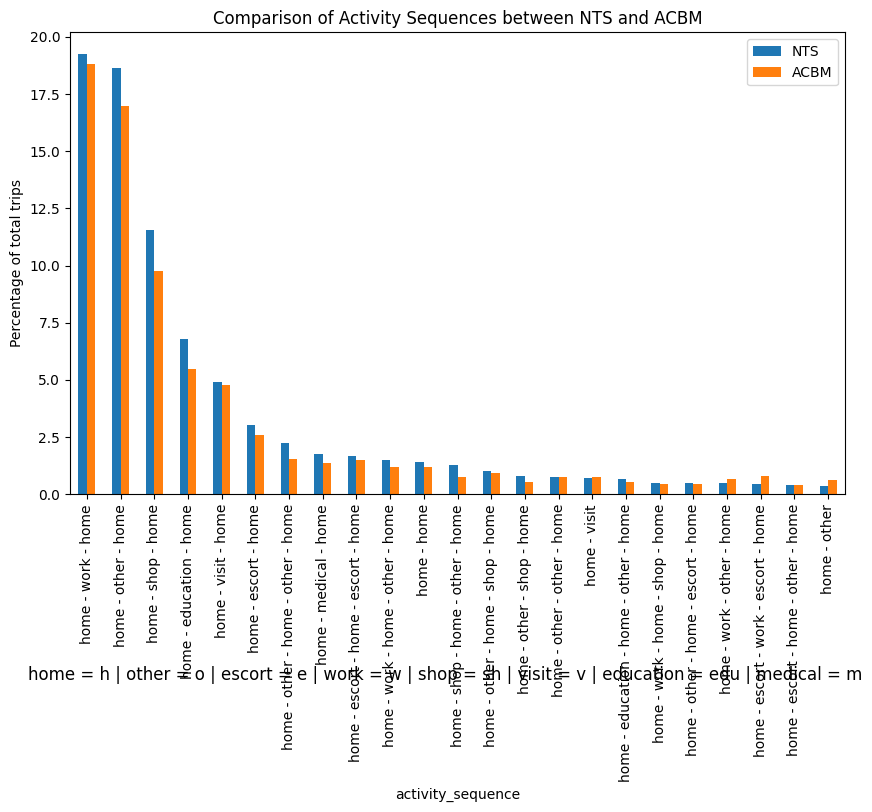

In [17]:
# join the two dataframes by 'activity_sequence'
sequence_nts_acbm = sequence_nts.merge(sequence_acbm, on='activity_sequence', how='inner').sort_values(by='count_nts', ascending=False)
sequence_nts_acbm

# Get % contribution of each unique activity sequence
sequence_nts_acbm['count_nts'] = sequence_nts_acbm['count_nts'] / sequence_nts_acbm['count_nts'].sum() * 100
sequence_nts_acbm['count_acbm'] = sequence_nts_acbm['count_acbm'] / sequence_nts_acbm['count_acbm'].sum() * 100

# Filter rows where both count columns are bigger than x %
x = 0.35

sequence_nts_acbm_filtered = sequence_nts_acbm[
    (sequence_nts_acbm['count_nts'] > x) & (sequence_nts_acbm['count_acbm'] > x)
]

# Plot the results as a bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

sequence_nts_acbm_filtered.plot(
    x='activity_sequence', 
    y=['count_nts', 'count_acbm'], 
    kind='bar', 
    ax=ax
)

plt.ylabel('Percentage of total trips')

plt.title('Comparison of Activity Sequences between NTS and ACBM')


# Generate custom legend
legend_labels = [f'{abbr} = {full}' for abbr, full in activity_mapping.items()]
custom_legend = ' | '.join(legend_labels)

# Add the custom legend to the plot
plt.legend(['NTS', 'ACBM'], loc='upper right')

# Add the custom legend below the chart
plt.figtext(0.5, -0.2, custom_legend, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


## Assigning: Trip distances

### Mean crowfly distance per trip purpose

Calculate travel distance for acbm activities

In [18]:
# TODO: add crs to config, and check other scripts

def calculate_distances(df: pd.DataFrame, 
                        start_wkt_col: str, 
                        end_wkt_col: str, 
                        crs_epsg: int = 4326, 
                        projected_epsg: int = 3857) -> pd.DataFrame:
    """
    Calculate distances between start and end geometries in a DataFrame.

    Parameters
    ----------

    df: pd.DataFrame
        DataFrame containing WKT geometry columns.
    start_wkt_col: str 
        Column name for start location WKT geometries.
    end_wkt_col: str
        Column name for end location WKT geometries.
    crs_epsg: int
        EPSG code for the original CRS (default is 4326 for WGS84).
    projected_epsg: int
        EPSG code for the projected CRS (default is 3857).

    Returns
    -------
    pd.DataFrame
        DataFrame with an additional 'distance' column containing distances in meters.
    """
        # Convert WKT strings to shapely geometries
    df['start_geometry'] = df[start_wkt_col].apply(wkt.loads)
    df['end_geometry'] = df[end_wkt_col].apply(wkt.loads)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='start_geometry')

    # Set the original CRS
    gdf.set_crs(epsg=crs_epsg, inplace=True)

    # Create a separate GeoDataFrame for the end geometries
    end_gdf = gdf.set_geometry('end_geometry')

    # Set the original CRS for the end_gdf
    end_gdf.set_crs(epsg=crs_epsg, inplace=True)

    # Transform both GeoDataFrames to a projected CRS
    gdf = gdf.to_crs(epsg=projected_epsg)
    end_gdf = end_gdf.to_crs(epsg=projected_epsg)

    # Calculate the distance between start and end geometries (in km)
    gdf['distance'] = round(gdf.geometry.distance(end_gdf.geometry) / 1000 , 1)

    return gdf

# Apply the function to legs_acbm_geo
legs_acbm_geo = calculate_distances(legs_acbm_geo, 'start_location_geometry_wkt', 'end_location_geometry_wkt')


In [19]:
legs_acbm_geo

,pid,hid,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration,start_location_id,end_location_id,start_location_geometry_wkt,end_location_geometry_wkt,start_geometry,end_geometry,distance
0,199,89,E00059031,E00058720,other,home,other,walk,1.0,1900-01-01 10:00:00,1900-01-01 10:45:00,0:45:00,1735597798,967294624,POINT (-1.3986079763910049 53.933681557220275),POINT (-1.5127441120162681 53.8180210228714),POINT (-155692.328 7157606.366),POINT (-1.5127441120162681 53.8180210228714),25.3
1,199,89,E00058720,E00059031,home,other,home,walk,2.0,1900-01-01 10:45:00,1900-01-01 11:30:00,0:45:00,967294624,1735597798,POINT (-1.5127441120162681 53.8180210228714),POINT (-1.3986079763910049 53.933681557220275),POINT (-168397.904 7135766.710),POINT (-1.3986079763910049 53.933681557220275),25.3
2,199,89,E00059031,E00057312,shop,home,shop,car,3.0,1900-01-01 12:00:00,1900-01-01 12:10:00,0:10:00,1735597798,157001772,POINT (-1.3986079763910049 53.933681557220275),POINT (-1.5448043854850726 53.780926914380444),POINT (-155692.328 7157606.366),POINT (-1.5448043854850726 53.780926914380444),33.1
3,199,89,E00057312,E00059031,home,shop,home,car,4.0,1900-01-01 12:45:00,1900-01-01 12:55:00,0:10:00,157001772,1735597798,POINT (-1.5448043854850726 53.780926914380444),POINT (-1.3986079763910049 53.933681557220275),POINT (-171966.838 7128775.165),POINT (-1.3986079763910049 53.933681557220275),33.1
4,199,89,E00059031,E00058564,work,home,work,car,5.0,1900-01-01 13:30:00,1900-01-01 13:50:00,0:20:00,1735597798,1428773232,POINT (-1.3986079763910049 53.933681557220275),POINT (-1.5029553091989152 53.789477653046596),POINT (-155692.328 7157606.366),POINT (-1.5029553091989152 53.789477653046596),29.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970,794026,334502,E00056891,E00057826,home,escort,home,car,4.0,1900-01-01 20:45:00,1900-01-01 21:05:00,0:20:00,6495819,1238900496,POINT (-1.584746581534615 53.793797905031),POINT (-1.5320470710998348 53.78289959964661),POINT (-176413.182 7131200.405),POINT (-1.5320470710998348 53.78289959964661),6.2
14971,794027,334502,E00057826,E00057536,escort,home,escort,car,1.0,1900-01-01 07:40:00,1900-01-01 07:55:00,0:15:00,1238900496,1362793606,POINT (-1.5320470710998348 53.78289959964661),POINT (-1.4689248218157287 53.796667804818235),POINT (-170546.700 7129146.824),POINT (-1.4689248218157287 53.796667804818235),7.5
14972,794027,334502,E00057536,E00057826,home,escort,home,pt,2.0,1900-01-01 15:00:00,1900-01-01 15:55:00,0:55:00,1362793606,1238900496,POINT (-1.4689248218157287 53.796667804818235),POINT (-1.5320470710998348 53.78289959964661),POINT (-163519.963 7131741.273),POINT (-1.5320470710998348 53.78289959964661),7.5
14973,794027,334502,E00057826,E00056882,other,home,other,pt,3.0,1900-01-01 18:35:00,1900-01-01 19:35:00,1:00:00,1238900496,1033390048,POINT (-1.5320470710998348 53.78289959964661),POINT (-1.5911288565275319 53.79690447266708),POINT (-170546.700 7129146.824),POINT (-1.5911288565275319 53.79690447266708),7.1


Plot the distance comparison

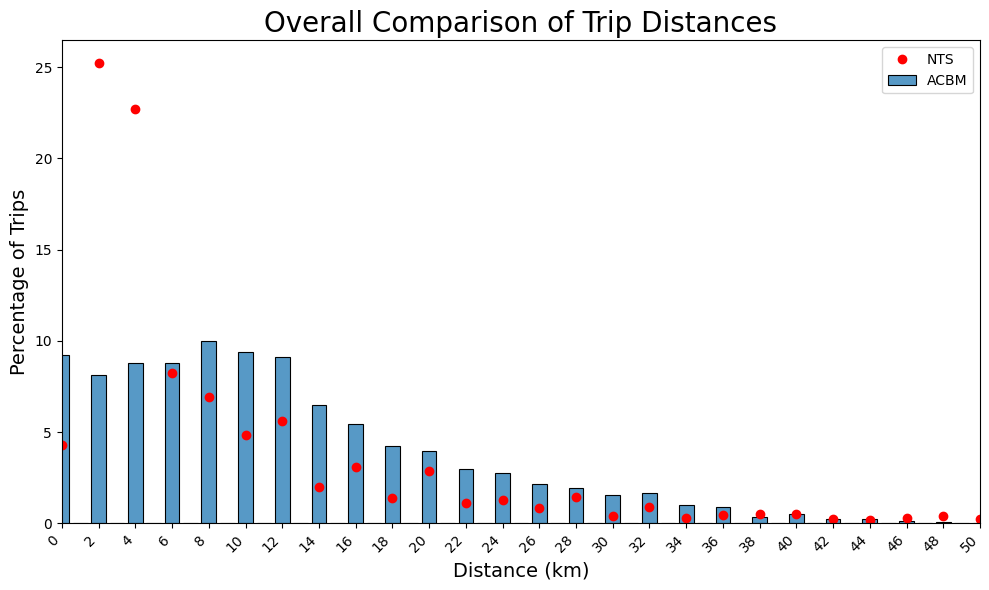

In [22]:

# Parameters
distance_column = 'distance'
bin_size = 2
distance_threshold = 50  # Set this to None if you don't want to use a threshold

# Create distance_binned column
legs_acbm_geo['distance_binned'] = (legs_acbm_geo[distance_column] / bin_size).round() * bin_size
legs_nts['distance_binned'] = (legs_nts[distance_column] / bin_size).round() * bin_size

# Define the bins
max_distance_data = max(legs_acbm_geo['distance_binned'].max(), legs_nts['distance_binned'].max())
if distance_threshold is not None:
    max_distance = min(distance_threshold, max_distance_data)
else:
    max_distance = max_distance_data
bins = range(0, int(max_distance) + bin_size, bin_size)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for legs_acbm_geo data
sns.histplot(legs_acbm_geo['distance_binned'], bins=bins, kde=False, discrete=True, stat='percent', ax=ax, label='ACBM', shrink=0.8)

# Add dots to represent the percentage values of legs_nts["distance_binned"]
nts_distance_counts = legs_nts['distance_binned'].value_counts(normalize=True).sort_index() * 100
if not nts_distance_counts.empty:
    bin_centers = nts_distance_counts.index
    ax.plot(bin_centers, nts_distance_counts.values, 'ro', label='NTS')  # 'ro' means red dot

# Set x-axis limits based on max_distance
ax.set_xlim(0, max_distance)
# Add x-axis ticks and labels for each bar
ax.set_xticks(bins)
ax.set_xticklabels([str(bin) for bin in bins], rotation=45, ha='right')


# Add labels and title
ax.set_xlabel('Distance (km)', fontsize=14)
ax.set_ylabel('Percentage of Trips', fontsize=14)
ax.set_title('Overall Comparison of Trip Distances', fontsize=20)
ax.legend()

# Adjust layout to make room for the main title and labels
plt.tight_layout()
plt.show()

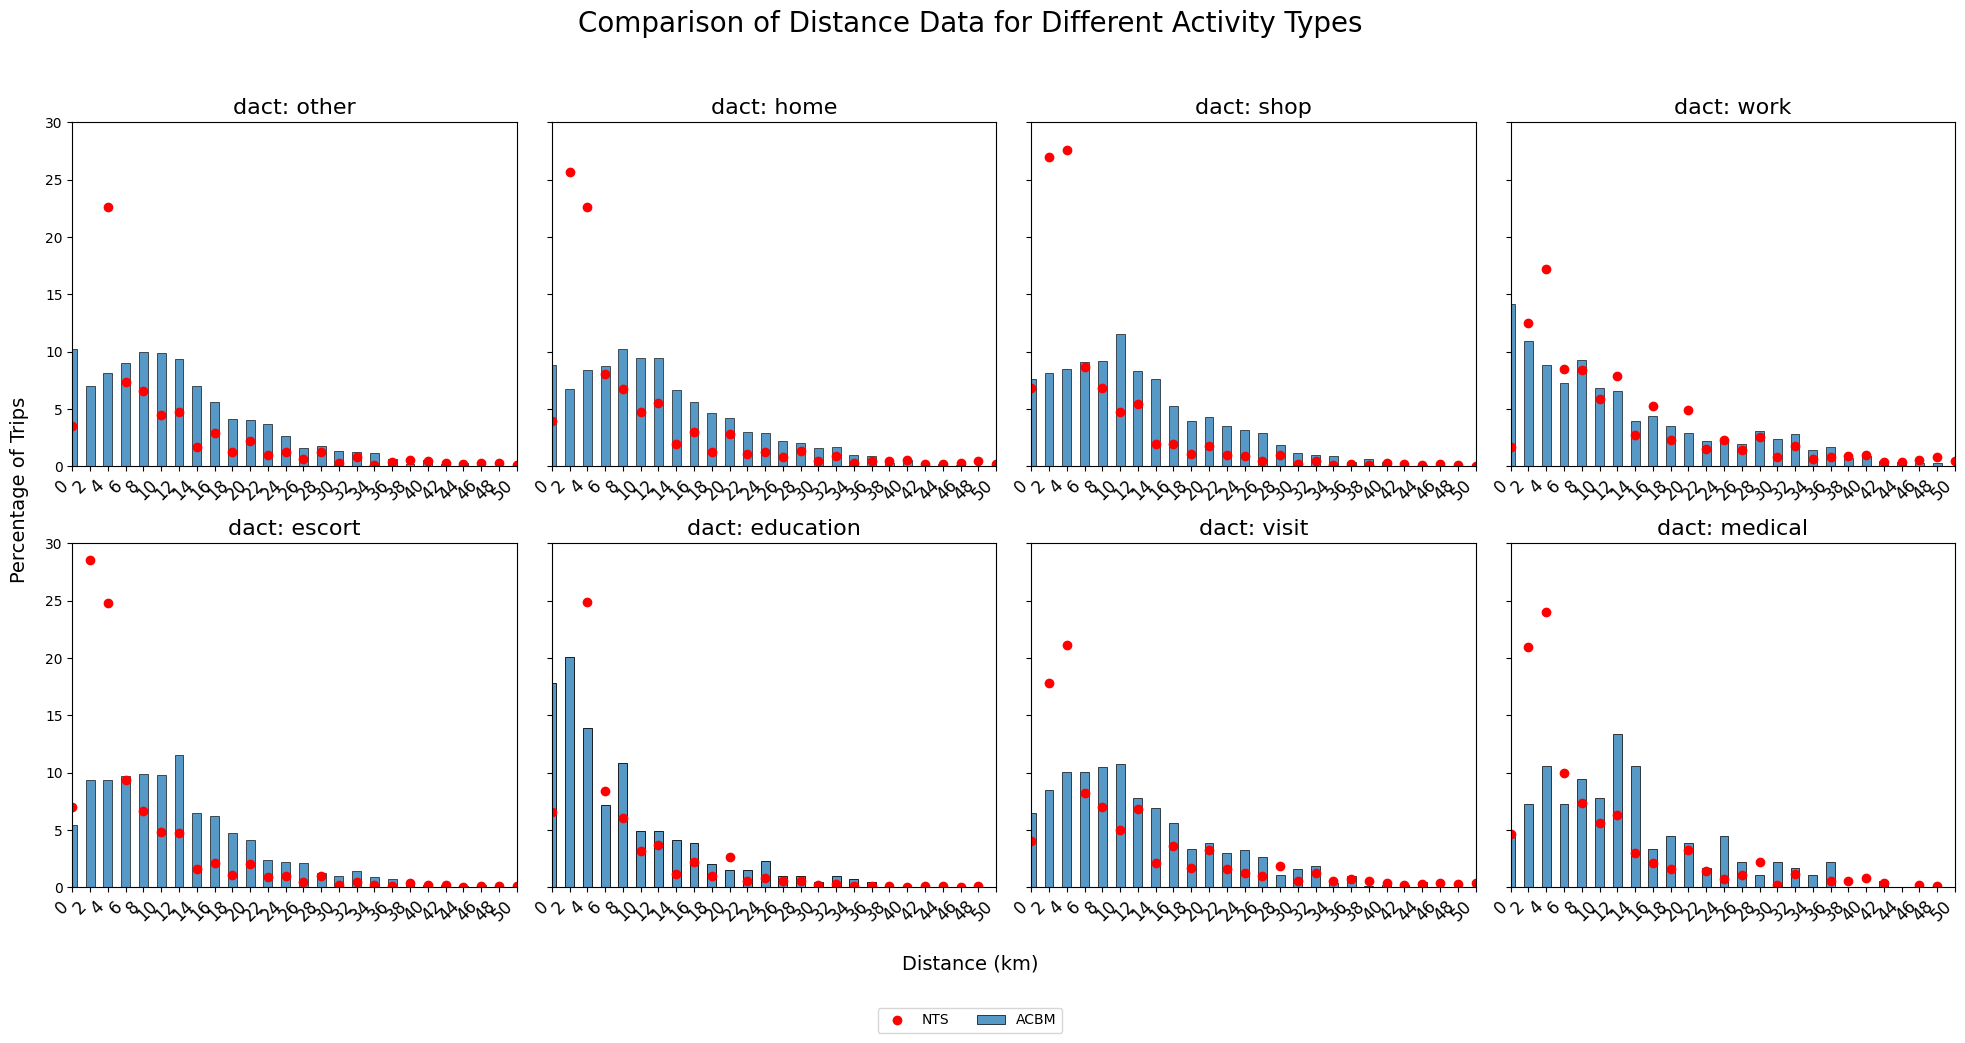

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Optional, Tuple

def plot_distance_comparison(legs_acbm: pd.DataFrame, 
                             legs_nts: pd.DataFrame, 
                             activity_column: str = 'dact', 
                             distance_column: str = 'distance', 
                             bin_size: int = 2, 
                             num_cols: int = 4, 
                             max_y_value: int = 100,
                             figsize: Tuple[int, int] = (20, 5),
                             distance_threshold: Optional[int] = None) -> None:
    """
    Plots a comparison of distance data for different activity types.

    Parameters
    ----------
    legs_acbm : pd.DataFrame
        DataFrame containing the ACBM data.
    legs_nts : pd.DataFrame
        DataFrame containing the NTS data.
    activity_column : str, optional
        The column name for the activity types. Default is 'dact'.
    distance_column : str, optional
        The column name for the distance values. Default is 'distance'.
    bin_size : int, optional
        The size of the bins for rounding distances. Default is 2 km.
    num_cols : int, optional
        The number of columns for the subplots. Default is 4.
    max_y_value : int, optional
        The maximum value for the y-axis. Default is 100.
    figsize : tuple of int
        The size of the figure. Default is (20, 5).
    distance_threshold : int, optional
        The maximum value for the x-axis. Default is None.

    Returns
    -------
    None
        This function generates and displays a plot but does not return any value.
    """
    # Create distance_binned column
    legs_acbm['distance_binned'] = (legs_acbm[distance_column] / bin_size).round() * bin_size
    legs_nts['distance_binned'] = (legs_nts[distance_column] / bin_size).round() * bin_size

    # Define the bins
    max_distance_data = max(legs_acbm['distance_binned'].max(), legs_nts['distance_binned'].max())
    if distance_threshold is not None:
        max_distance = min(distance_threshold, max_distance_data)
    else:
        max_distance = max_distance_data
    bins = range(0, int(max_distance) + bin_size, bin_size)

    # Get unique dact values
    unique_dact_values = legs_acbm[activity_column].unique()

    # Create a figure with subplots
    num_plots = len(unique_dact_values)
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], num_rows * figsize[1]), sharey=True)
    axes = axes.flatten()

    # Iterate over unique dact values and create plots
    for i, dact_value in enumerate(unique_dact_values):
        ax = axes[i]
        acbm_data = legs_acbm[legs_acbm[activity_column] == dact_value]
        nts_data = legs_nts[legs_nts[activity_column] == dact_value]

        # Plot histogram for acbm_data
        hist = sns.histplot(acbm_data['distance_binned'], bins=bins, kde=False, discrete=True, stat='percent', ax=ax, label='ACBM')
        ax.set_title(f'dact: {dact_value}', fontsize=16)
        ax.tick_params(axis='x', rotation=45, labelsize=12)  # Rotate x-axis labels by 45 degrees

        # Set x-axis limits based on max_distance
        ax.set_xlim(0, max_distance)
        # Set y-axis limits based on max_y_value
        ax.set_ylim(0, max_y_value)

        # Add x-axis ticks and labels for each bar
        ax.set_xticks(bins)
        ax.set_xticklabels([str(bin) for bin in bins], rotation=45, ha='right')

        # Remove individual subplot labels
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Add dots to represent the percentage values of legs_nts["distance_binned"]
        nts_distance_counts = nts_data['distance_binned'].value_counts(normalize=True).sort_index() * 100
        if not nts_distance_counts.empty:
            bin_centers = nts_distance_counts.index
            ax.plot(bin_centers, nts_distance_counts.values, 'ro', label='NTS')  # 'ro' means red dot

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a main legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    # Add a main title to the figure
    fig.suptitle('Comparison of Distance Data for Different Activity Types', fontsize=20)

    # Add a single centered x-label and y-label
    fig.text(0.5, 0.02, 'Distance (km)', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Percentage of Trips', va='center', rotation='vertical', fontsize=14)

    # Adjust layout to make room for the main title and labels
    plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
    plt.show()

# Example usage
plot_distance_comparison(legs_acbm_geo, legs_nts, distance_threshold=50, max_y_value=30)

### Test number of intrazonal trips

To ensure that our intrazonal logic is working. It appears we are underestimating the number of trips that are 2-4km and 4-6km. 

This could also be a result of travel times not correlating directly with distance, and that effect being more pronounced in shorter trips.


In [41]:
# add binary column to identify intrazonal trips
legs_acbm['intrazonal'] = legs_acbm['ozone'] == legs_acbm['dzone']


,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration,tst_hour,tet_hour,oact_abr,dact_abr,intrazonal
0,0,199,89,NaN,E00059031,E00058720,other,home,other,walk,1.0,1900-01-01 10:00:00,1900-01-01 10:45:00,0:45:00,10,10,h,o,False
1,1,199,89,NaN,E00058720,E00059031,home,other,home,walk,2.0,1900-01-01 10:45:00,1900-01-01 11:30:00,0:45:00,10,11,o,h,False
2,2,199,89,NaN,E00059031,E00057312,shop,home,shop,car,3.0,1900-01-01 12:00:00,1900-01-01 12:10:00,0:10:00,12,12,h,sh,False
3,3,199,89,NaN,E00057312,E00059031,home,shop,home,car,4.0,1900-01-01 12:45:00,1900-01-01 12:55:00,0:10:00,12,12,sh,h,False
4,4,199,89,NaN,E00059031,E00058564,work,home,work,car,5.0,1900-01-01 13:30:00,1900-01-01 13:50:00,0:20:00,13,13,h,w,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970,14970,794026,334502,NaN,E00056891,E00057826,home,escort,home,car,4.0,1900-01-01 20:45:00,1900-01-01 21:05:00,0:20:00,20,21,e,h,False
14971,14971,794027,334502,NaN,E00057826,E00057536,escort,home,escort,car,1.0,1900-01-01 07:40:00,1900-01-01 07:55:00,0:15:00,7,7,h,e,False
14972,14972,794027,334502,NaN,E00057536,E00057826,home,escort,home,pt,2.0,1900-01-01 15:00:00,1900-01-01 15:55:00,0:55:00,15,15,e,h,False
14973,14973,794027,334502,NaN,E00057826,E00056882,other,home,other,pt,3.0,1900-01-01 18:35:00,1900-01-01 19:35:00,1:00:00,18,19,h,o,False


        purp  total_count  intrazonal_count  percentage
0  education          389                 3    0.771208
1     escort         1708                20    1.170960
2       home         6473               278    4.294763
3    medical          181                 2    1.104972
4      other         2487               119    4.784881
5       shop         1235                37    2.995951
6      visit          829                15    1.809409
7       work         1673                88    5.260012


/tmp/ipykernel_540731/3001768473.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=merged_counts, x='purp', y='percentage', palette='viridis')


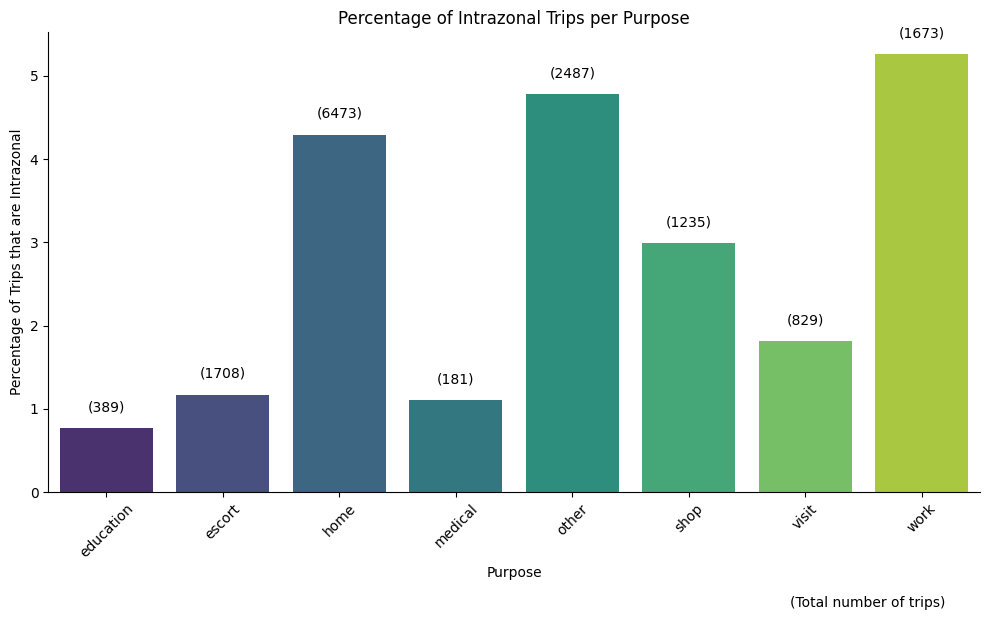

In [64]:
# Total number of trips per trip purpose
total_counts = legs_acbm.groupby('purp').size().reset_index(name='total_count')

# Filter the DataFrame to include only rows where intrazonal_trips is TRUE
intrazonal_trips_true = legs_acbm[legs_acbm['intrazonal'] == True]

# Total number of intrazonal trips per trip purpose
intrazonal_counts = intrazonal_trips_true.groupby('purp').size().reset_index(name='intrazonal_count')

# Merge the two DataFrames and calculate intrazonal %
merged_counts = pd.merge(total_counts, intrazonal_counts, on='purp', how='left')
# Fill NaN values with 0 (in case there are purp groups with no intrazonal trips)
merged_counts['intrazonal_count'] = merged_counts['intrazonal_count'].fillna(0)
# Calculate the percentage of intrazonal trips
merged_counts['percentage'] = (merged_counts['intrazonal_count'] / merged_counts['total_count']) * 100

# Print the resulting DataFrame
print(merged_counts)

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=merged_counts, x='purp', y='percentage', palette='viridis')
plt.title('Percentage of Intrazonal Trips per Purpose')
plt.xlabel('Purpose')
plt.ylabel('Percentage of Trips that are Intrazonal')
plt.xticks(rotation=45)

# Add text annotations above each bar
for index, row in merged_counts.iterrows():
    barplot.text(index, row['percentage'] + 0.2, f"({int(row['total_count'])})", color='black', ha="center")

# Remove the top and right spines (box frame) from the plot
barplot.spines['top'].set_visible(False)
barplot.spines['right'].set_visible(False)



# Add footnote on the right below the plot
plt.figtext(0.95, -0.02, '(Total number of trips)', ha='right', fontsize=10)

plt.tight_layout()
plt.show()

### Crowfly distance cumulative chart (KM distance vs. % of trips)